2024-08-14 17:13:37.985858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 17:13:38.742802: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 17:13:41.164328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-08-14 17:13:41.165020: W tensorflow/compiler/xla/stream_exec

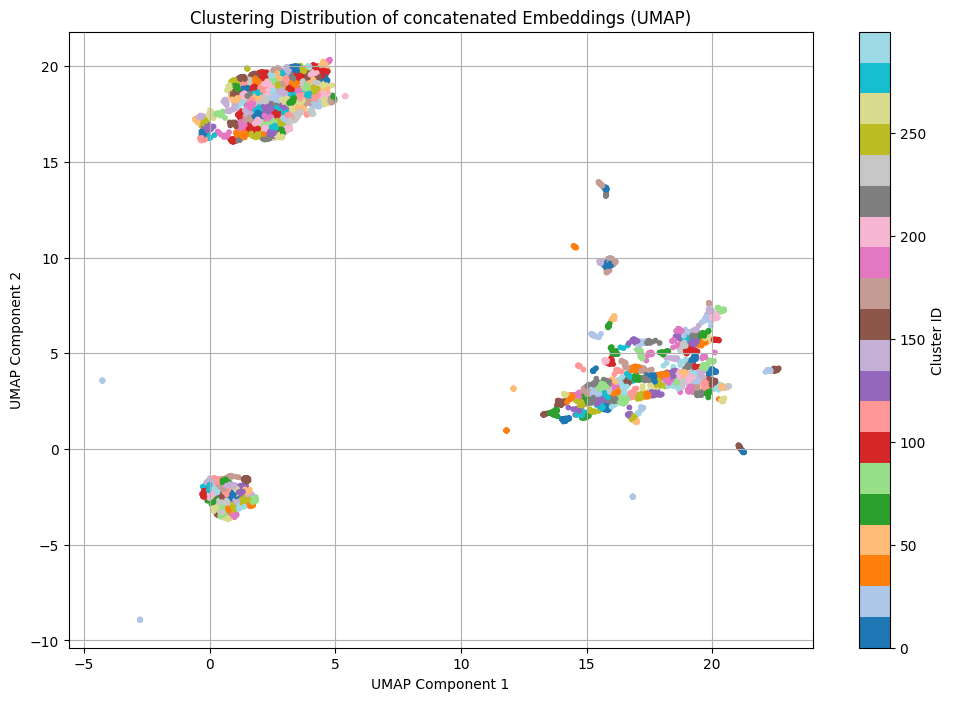

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


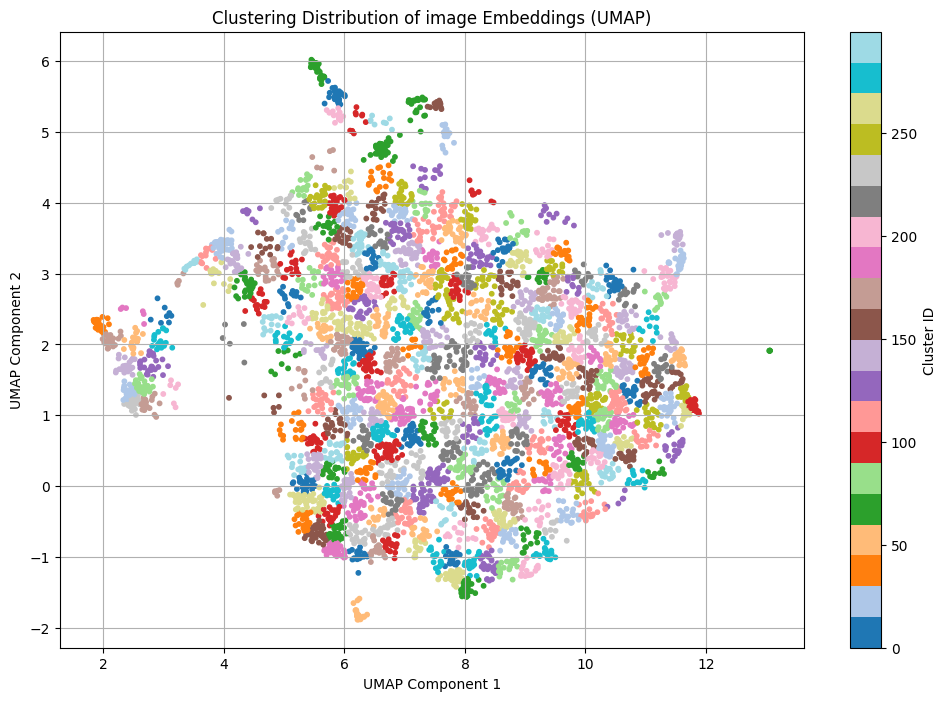

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


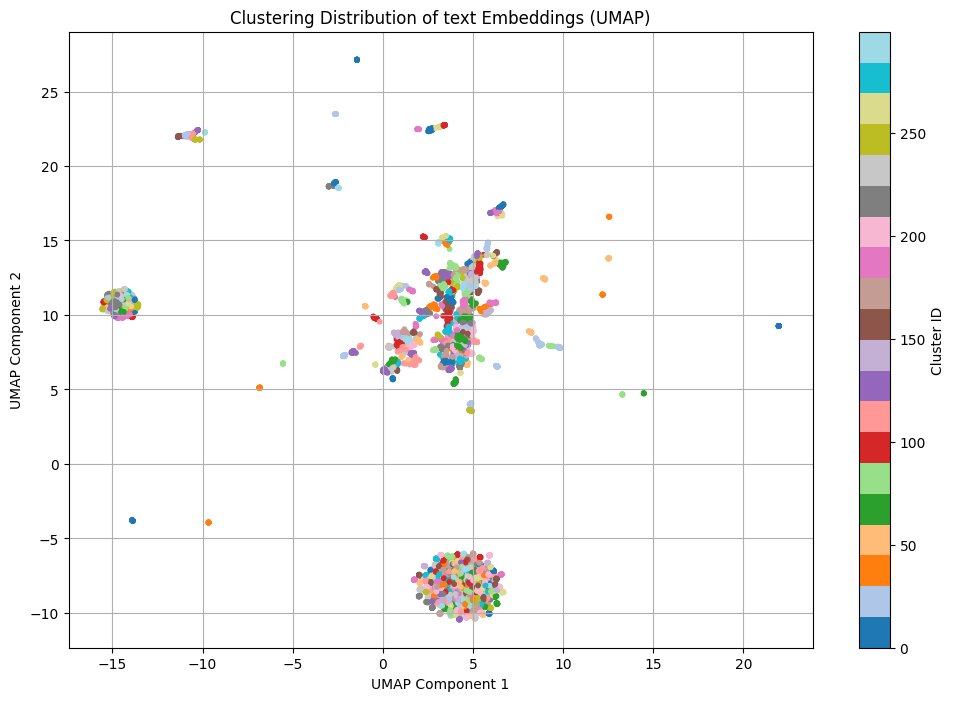

Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3


In [1]:
import os
import json
import torch
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

# Paths
embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/concatenated_embeddings_tag'
image_embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/image_embeddings_tag'
text_embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/text_embeddings_tag'
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_files):
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc="Loading embeddings"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    return torch.cat(embeddings, dim=0).cpu()  # Move to CPU

# Load concatenated embeddings
concatenated_embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
concatenated_embeddings = load_embeddings(concatenated_embedding_files)

# Load image embeddings
image_embedding_files = [os.path.join(image_embedding_folder, fname) for fname in os.listdir(image_embedding_folder) if fname.endswith('.pt')]
image_embeddings = load_embeddings(image_embedding_files)

# Load text embeddings
text_embedding_files = [os.path.join(text_embedding_folder, fname) for fname in os.listdir(text_embedding_folder) if fname.endswith('.pt')]
text_embeddings = load_embeddings(text_embedding_files)

# Set number of clusters
n_clusters = 300

# Function to perform clustering and save results
def perform_clustering(embeddings, embedding_files, label, output_folder):
    # Apply UMAP before clustering
    umap_model = umap.UMAP(n_components=2, random_state=0)
    reduced_embeddings = umap_model.fit_transform(embeddings.numpy())
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)  # Use KMeans++
    labels = kmeans.fit_predict(reduced_embeddings)  # `embeddings` is now on CPU
    
    # Save clustered images to output folders based on the clustering results
    for idx, label_id in tqdm(enumerate(labels), desc=f"Saving clustered images ({label})", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label_id))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))
    
    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label_id) for idx, label_id in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    return labels


# Perform clustering on concatenated, image, and text embeddings
concatenated_labels = perform_clustering(concatenated_embeddings, concatenated_embedding_files, 'concatenated', output_folder)
image_labels = perform_clustering(image_embeddings, image_embedding_files, 'image', output_folder)
text_labels = perform_clustering(text_embeddings, text_embedding_files, 'text', output_folder)

# Function to visualize clustering results using UMAP
def visualize_umap(embeddings, labels, label, output_folder):
    umap_model = umap.UMAP(n_components=2, random_state=0)
    reduced_embeddings = umap_model.fit_transform(embeddings.numpy())

    # Plot the clustering results
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab20', s=10)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title(f'Clustering Distribution of {label} Embeddings (UMAP)')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'clustering_distribution_umap_{label}_tag.png'))
    plt.show()

# Visualize and save UMAP plots
visualize_umap(concatenated_embeddings, concatenated_labels, 'concatenated', output_folder)
visualize_umap(image_embeddings, image_labels, 'image', output_folder)
visualize_umap(text_embeddings, text_labels, 'text', output_folder)

print(f'Clustering complete. Output saved to {output_folder}')


Loading embeddings:   0%|          | 0/5912 [00:00<?, ?it/s]

Loading embeddings: 100%|██████████| 5912/5912 [00:01<00:00, 4828.26it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/

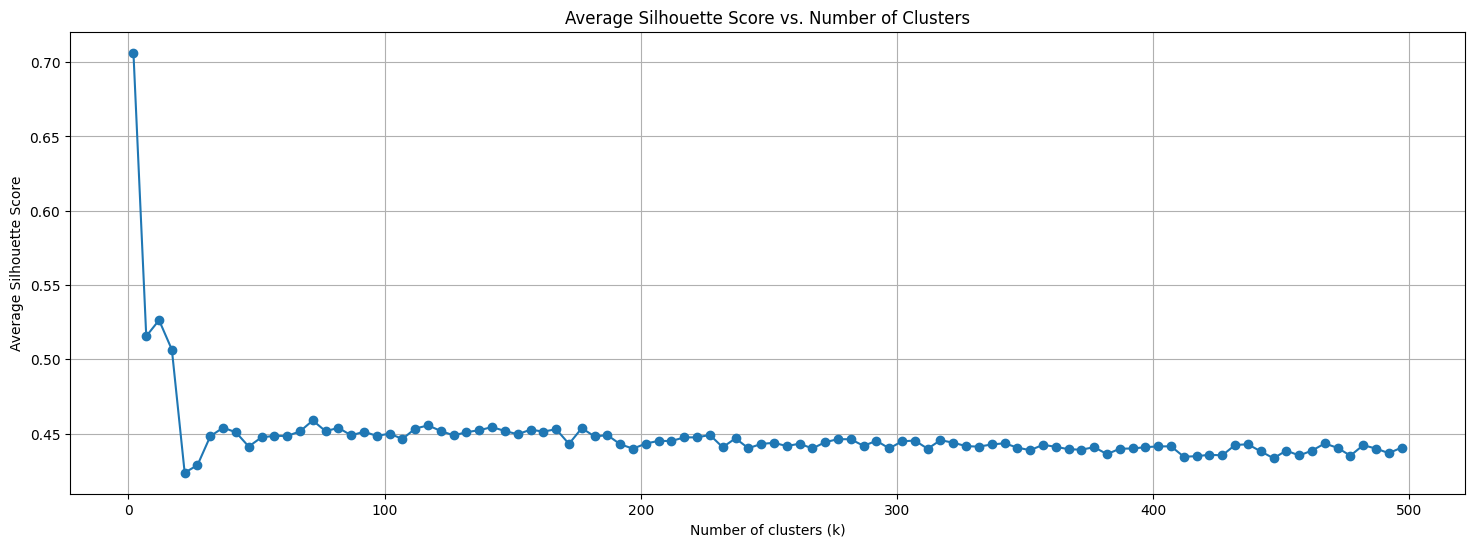

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images: 100%|██████████| 5912/5912 [00:00<00:00, 77479.11it/s]

Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3


In [4]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import shutil
import umap

# Paths
embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/concatenated_embeddings_tag'
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Load concatenated embeddings
embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]

# Load all embeddings into a list
all_embeddings = []
for embedding_file in tqdm(embedding_files, desc="Loading embeddings"):
    embedding = torch.load(embedding_file)
    all_embeddings.append(embedding)

# Concatenate all embeddings into a single tensor
all_embeddings = torch.cat(all_embeddings, dim=0).cpu()  # Move to CPU

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=0)
reduced_embeddings = umap_model.fit_transform(all_embeddings.numpy())

# Determine optimal number of clusters using Average Silhouette Method
silhouette_scores = []
k_values = list(range(2, 501, 5))  # k values from 2 to 500 with a step of 5

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(reduced_embeddings)
    
    if len(set(labels)) > 1:  # Check if we have more than 1 label
        score = silhouette_score(reduced_embeddings, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Append a placeholder score if there's only one label

# Plot silhouette scores
plt.figure(figsize=(18, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Select the optimal number of clusters based on the silhouette scores
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(reduced_embeddings)

# Save clustered images to output folders based on the clustering results
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    
    # Extract corresponding image file name from embedding file name
    embedding_file = embedding_files[idx]
    image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
    
    # Define source image path
    source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
    
    # Copy image to corresponding cluster folder
    if os.path.exists(source_image_path):
        shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

# Save clustering labels to JSON file
labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)

print(f'Clustering complete. Output saved to {output_folder}')


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/concatenated_embeddings_tag: 100%|██████████| 5912/5912 [00:01<00:00, 4957.43it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_in

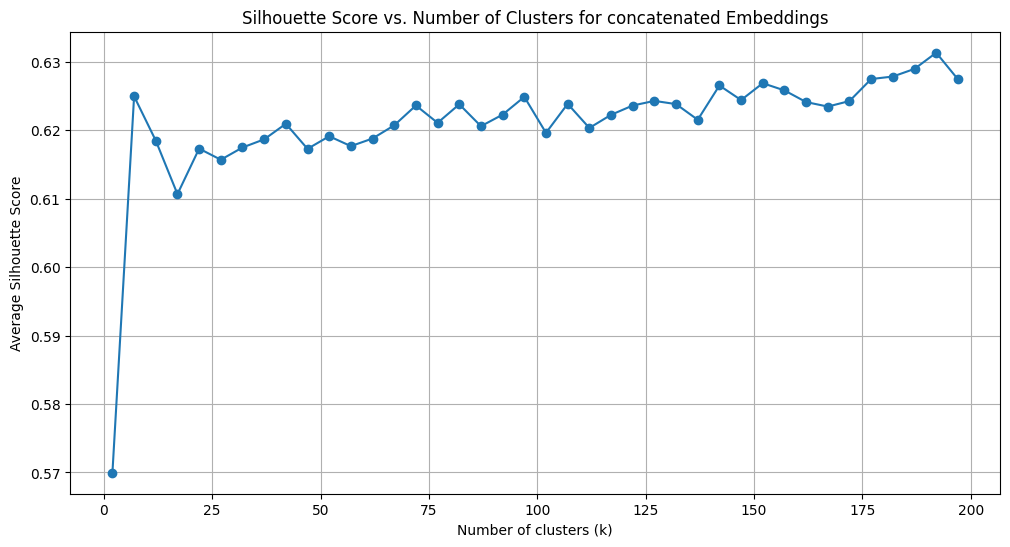

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images for concatenated: 100%|██████████| 5912/5912 [00:00<00:00, 83801.60it/s]


Clustering complete for 0. Output saved to /data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/image_embeddings_tag: 100%|██████████| 5912/5912 [00:01<00:00, 5191.73it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, 

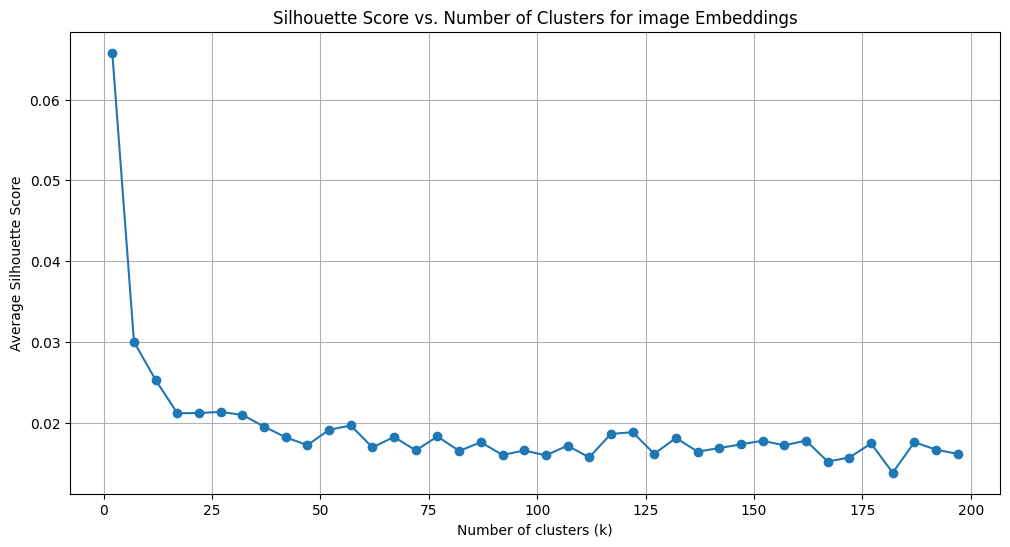

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images for image: 100%|██████████| 5912/5912 [00:00<00:00, 83593.95it/s]


Clustering complete for 0. Output saved to /data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/text_embeddings_tag: 100%|██████████| 8892/8892 [00:01<00:00, 5229.06it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, d

In [5]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import shutil

# Paths
embedding_folders = {
    'concatenated': '/data1/dxw_data/llm/redbook_final/script_next/concatenated_embeddings_tag',
    'image': '/data1/dxw_data/llm/redbook_final/script_next/image_embeddings_tag',
    'text': '/data1/dxw_data/llm/redbook_final/script_next/text_embeddings_tag'
}
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_folder):
    embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc=f"Loading embeddings from {embedding_folder}"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Move to CPU
    return embeddings, embedding_files

# Function to perform clustering and calculate silhouette scores
def cluster_and_silhouette(embeddings, embedding_files, label, output_folder):
    silhouette_scores = []
    k_values = list(range(2, 201, 5))  # k values from 2 to 100 with a step of 5

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
        
        if len(set(labels)) > 1:  # Check if we have more than 1 label
            score = silhouette_score(embeddings.numpy(), labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Append a placeholder score if there's only one label
    
    # Plot Silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'silhouette_{label}.png'))
    plt.show()

    # Select the optimal number of clusters based on the silhouette scores
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU

    # Save clustered images to output folders based on the clustering results
    for idx, label in tqdm(enumerate(labels), desc=f"Saving clustered images for {label}", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    print(f'Clustering complete for {label}. Output saved to {output_folder}')

# Process each type of embeddings
for label, folder in embedding_folders.items():
    embeddings, embedding_files = load_embeddings(folder)
    cluster_and_silhouette(embeddings, embedding_files, label, output_folder)


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/text_embeddings_tag: 100%|██████████| 8892/8892 [00:01<00:00, 5177.78it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, d

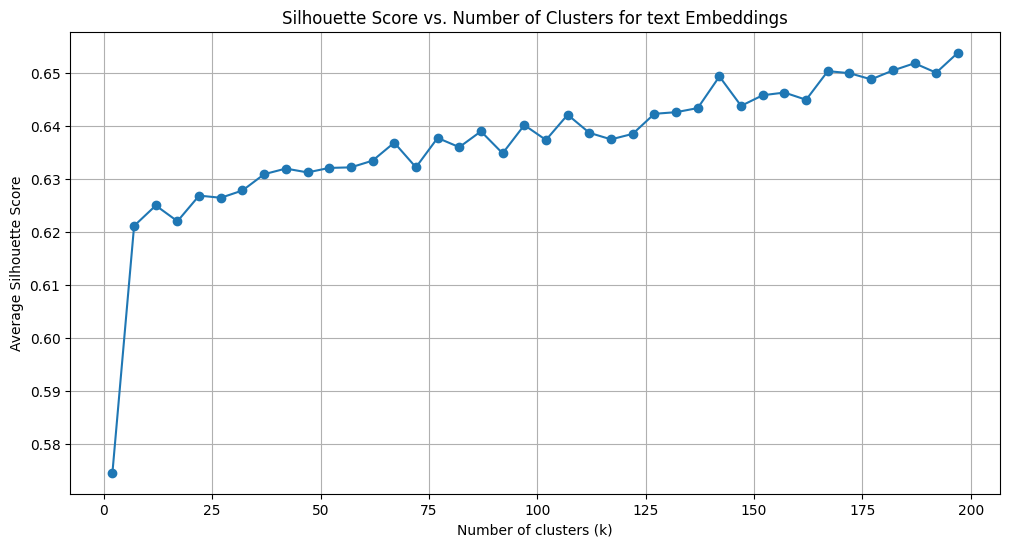

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images for text:   0%|          | 0/8892 [00:00<?, ?it/s]


NameError: name 'embedding_folder' is not defined

In [2]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import shutil

# Paths
embedding_folders = {
    'text': '/data1/dxw_data/llm/redbook_final/script_next/text_embeddings_tag'
}
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/combined_seg_img_pure_094_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_folder):
    embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc=f"Loading embeddings from {embedding_folder}"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Move to CPU
    return embeddings, embedding_files

# Function to perform clustering and calculate silhouette scores
def cluster_and_silhouette(embeddings, embedding_files, label, output_folder):
    silhouette_scores = []
    k_values = list(range(2, 501, 5))  # k values from 2 to 100 with a step of 5

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
        
        if len(set(labels)) > 1:  # Check if we have more than 1 label
            score = silhouette_score(embeddings.numpy(), labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Append a placeholder score if there's only one label
    
    # Plot Silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'silhouette_{label}.png'))
    plt.show()

    # Select the optimal number of clusters based on the silhouette scores
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU

    # Save clustered images to output folders based on the clustering results
    for idx, label in tqdm(enumerate(labels), desc=f"Saving clustered images for {label}", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    print(f'Clustering complete for {label}. Output saved to {output_folder}')

# Process each type of embeddings
for label, folder in embedding_folders.items():
    embeddings, embedding_files = load_embeddings(folder)
    cluster_and_silhouette(embeddings, embedding_files, label, output_folder)


In [2]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import shutil

# Paths
embedding_folders = {
    'concatenated': '/data1/dxw_data/llm/redbook_final/script_next/allbg_concatenated_embeddings_tag',
    'image': '/data1/dxw_data/llm/redbook_final/script_next/allbg_image_embeddings_tag',
    'text': '/data1/dxw_data/llm/redbook_final/script_next/allbg_text_embeddings_tag'
}
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/allbg_cloth_95_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_folder):
    embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc=f"Loading embeddings from {embedding_folder}"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Move to CPU
    return embeddings, embedding_files

# Function to perform clustering and calculate silhouette scores
def cluster_and_silhouette(embeddings, embedding_files, label, output_folder, embedding_folder):
    silhouette_scores = []
    k_values = list(range(2, 101, 5))  # k values from 2 to 100 with a step of 5

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
        
        if len(set(labels)) > 1:  # Check if we have more than 1 label
            score = silhouette_score(embeddings.numpy(), labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Append a placeholder score if there's only one label
    
    # Plot Silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'silhouette_{label}.png'))
    plt.show()

    # Select the optimal number of clusters based on the silhouette scores
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU

    # Save clustered images to output folders based on the clustering results
    for idx, label in tqdm(enumerate(labels), desc=f"Saving clustered images for {label}", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    print(f'Clustering complete for {label}. Output saved to {output_folder}')

# Process each type of embeddings
for label, folder in embedding_folders.items():
    embeddings, embedding_files = load_embeddings(folder)
    cluster_and_silhouette(embeddings, embedding_files, label, output_folder, folder)


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/allbg_concatenated_embeddings_tag: 0it [00:00, ?it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/text_embeddings: 100%|██████████| 5912/5912 [00:01<00:00, 4572.49it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defau

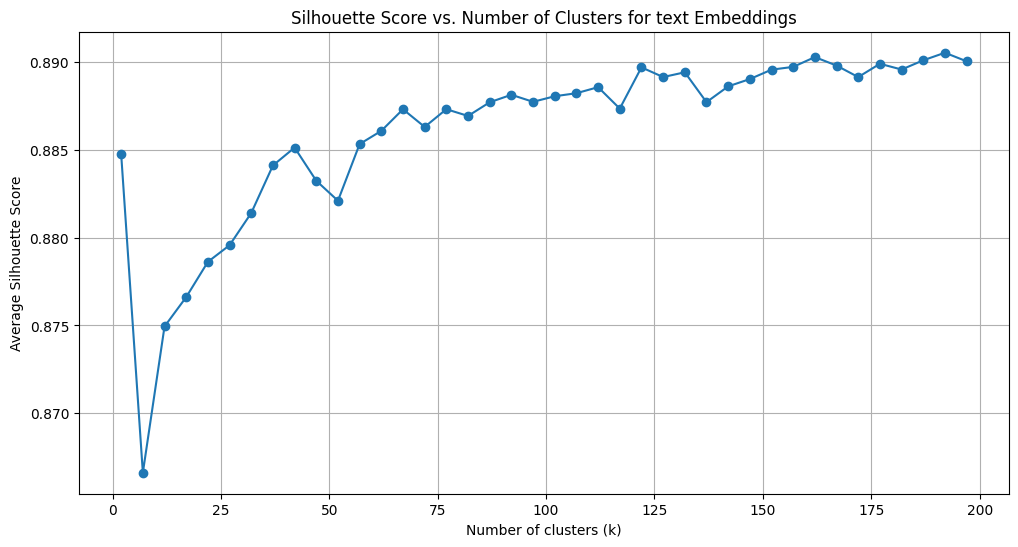

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images for text: 100%|██████████| 5912/5912 [00:00<00:00, 74269.04it/s]

Clustering complete for 0. Output saved to /data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3


In [6]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import shutil

# Paths
embedding_folders = {
    # 'concatenated': '/data1/dxw_data/llm/redbook_final/script_next/concatenated_embeddings_tag',
    # 'image': '/data1/dxw_data/llm/redbook_final/script_next/image_embeddings_tag',
    'text': '/data1/dxw_data/llm/redbook_final/script_next/text_embeddings'
}
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_folder):
    embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc=f"Loading embeddings from {embedding_folder}"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Move to CPU
    return embeddings, embedding_files

# Function to perform clustering and calculate silhouette scores
def cluster_and_silhouette(embeddings, embedding_files, label, output_folder, embedding_folder):
    silhouette_scores = []
    k_values = list(range(2, 201, 5))  # k values from 2 to 100 with a step of 5

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
        
        if len(set(labels)) > 1:  # Check if we have more than 1 label
            score = silhouette_score(embeddings.numpy(), labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Append a placeholder score if there's only one label
    
    # Plot Silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'silhouette_{label}.png'))
    plt.show()

    # Select the optimal number of clusters based on the silhouette scores
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU

    # Save clustered images to output folders based on the clustering results
    for idx, label in tqdm(enumerate(labels), desc=f"Saving clustered images for {label}", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    print(f'Clustering complete for {label}. Output saved to {output_folder}')

# Process each type of embeddings
for label, folder in embedding_folders.items():
    embeddings, embedding_files = load_embeddings(folder)
    cluster_and_silhouette(embeddings, embedding_files, label, output_folder, folder)


Loading embeddings:   0%|          | 0/5912 [00:00<?, ?it/s]

Loading embeddings: 100%|██████████| 8892/8892 [00:01<00:00, 5555.82it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images (concatenated): 100%|██████████| 5912/5912 [00:00<00:00, 88244.57it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images (image): 100%|██████████| 5912/5912 [00:00<00:00, 84246.89it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to '

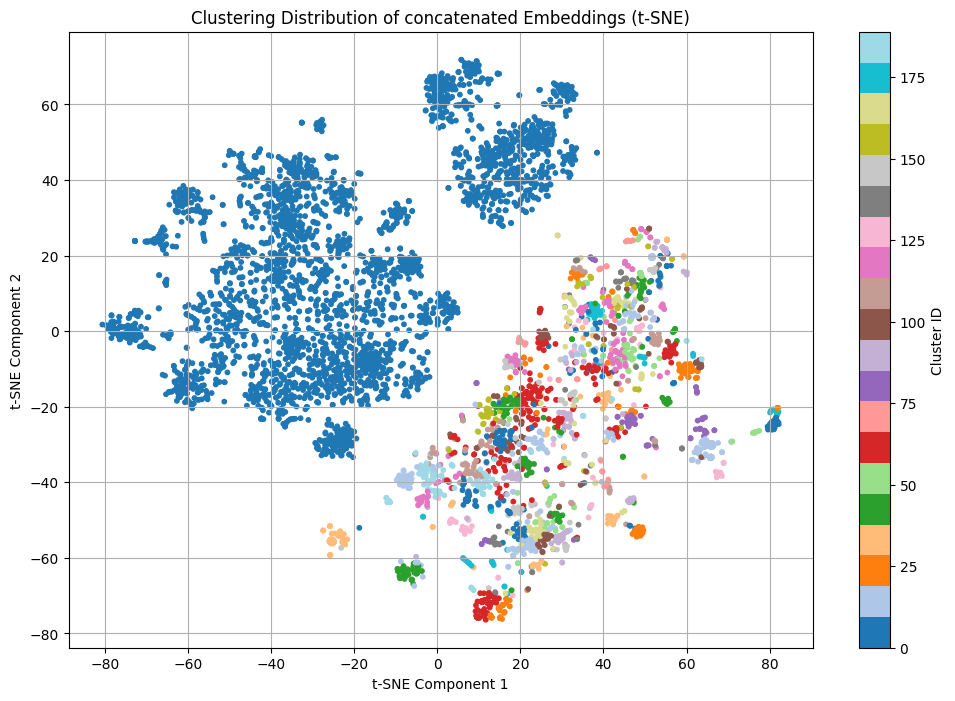

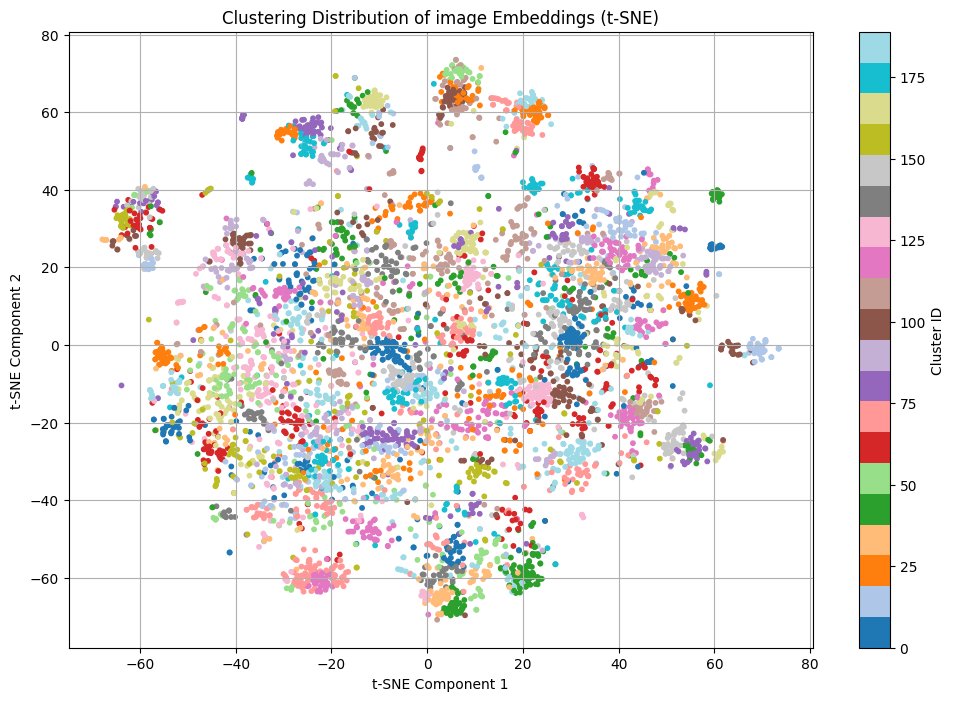

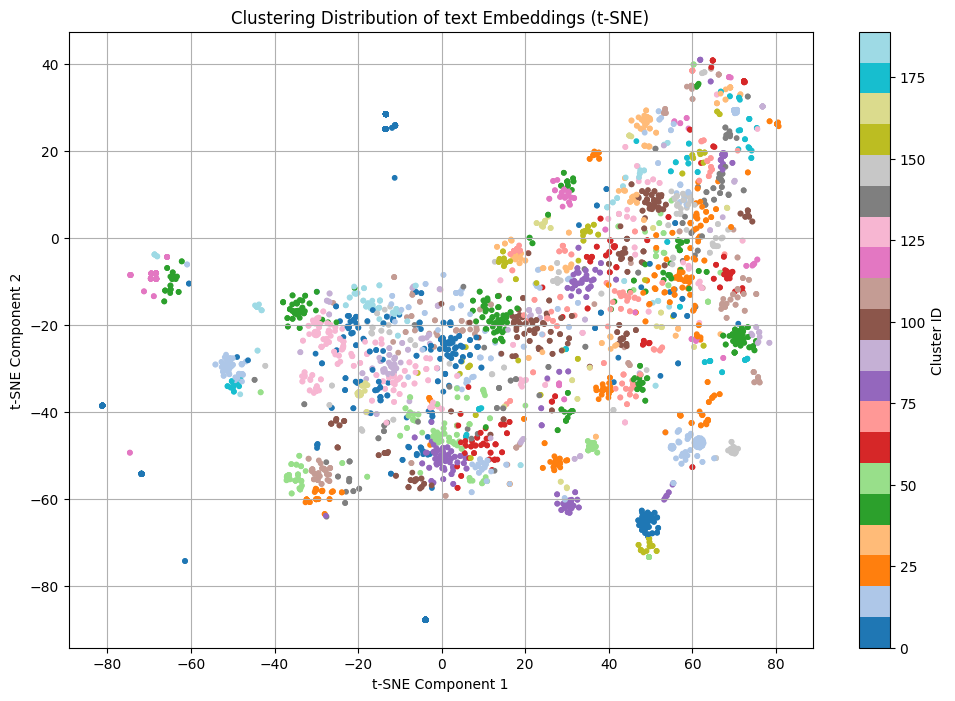

Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3


In [7]:
import os
import json
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

# Paths
embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/concatenated_embeddings_tag'
image_embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/image_embeddings_tag'
text_embedding_folder = '/data1/dxw_data/llm/redbook_final/script_next/text_embeddings_tag'
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/seg_cloth_95_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_files):
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc="Loading embeddings"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    return torch.cat(embeddings, dim=0).cpu()  # Move to CPU

# Load concatenated embeddings
concatenated_embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
concatenated_embeddings = load_embeddings(concatenated_embedding_files)

# Load image embeddings
image_embedding_files = [os.path.join(image_embedding_folder, fname) for fname in os.listdir(image_embedding_folder) if fname.endswith('.pt')]
image_embeddings = load_embeddings(image_embedding_files)

# Load text embeddings
text_embedding_files = [os.path.join(text_embedding_folder, fname) for fname in os.listdir(text_embedding_folder) if fname.endswith('.pt')]
text_embeddings = load_embeddings(text_embedding_files)

# Set number of clusters
n_clusters = 190

# Function to perform clustering and save results
def perform_clustering(embeddings, embedding_files, label, output_folder):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
    
    # Save clustered images to output folders based on the clustering results
    for idx, label_id in tqdm(enumerate(labels), desc=f"Saving clustered images ({label})", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label_id))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))
    
    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label_id) for idx, label_id in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    return labels

# Perform clustering on concatenated, image, and text embeddings
concatenated_labels = perform_clustering(concatenated_embeddings, concatenated_embedding_files, 'concatenated', output_folder)
image_labels = perform_clustering(image_embeddings, image_embedding_files, 'image', output_folder)
text_labels = perform_clustering(text_embeddings, text_embedding_files, 'text', output_folder)

# Function to visualize clustering results using t-SNE
def visualize_tsne(embeddings, labels, label, output_folder):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(embeddings.numpy())

    # Plot the clustering results
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab20', s=10)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title(f'Clustering Distribution of {label} Embeddings (t-SNE)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'clustering_distribution_tsne_{label}.png'))
    plt.show()

# Visualize and save t-SNE plots
visualize_tsne(concatenated_embeddings, concatenated_labels, 'concatenated', output_folder)
visualize_tsne(image_embeddings, image_labels, 'image', output_folder)
visualize_tsne(text_embeddings, text_labels, 'text', output_folder)

print(f'Clustering complete. Output saved to {output_folder}')


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/random_sampled_image_embeddings: 100%|██████████| 5000/5000 [00:02<00:00, 2033.59it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_v

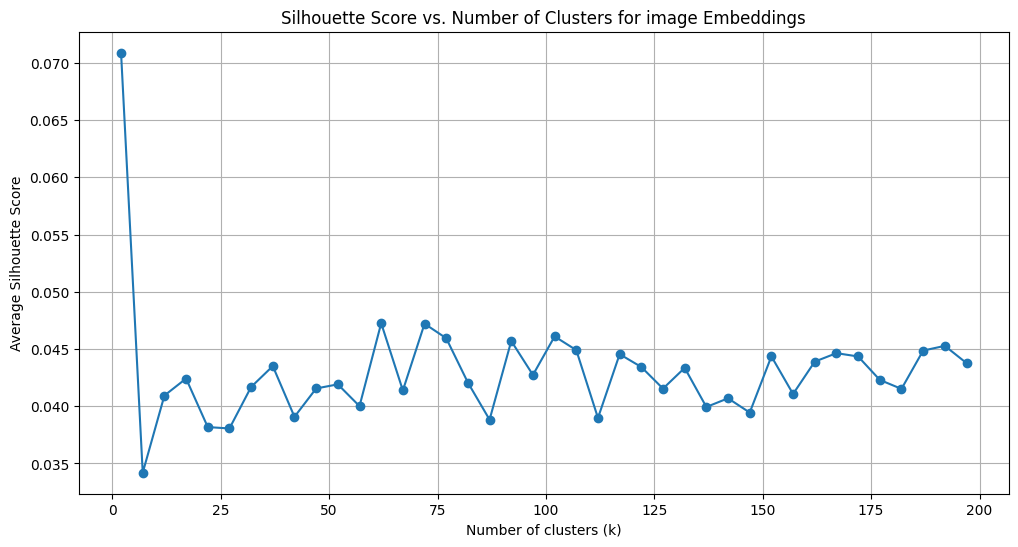

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images for image: 100%|██████████| 5000/5000 [00:00<00:00, 72368.99it/s]

Clustering complete for 1. Output saved to /data1/dxw_data/llm/redbook_final/script_next/random_sampled_cluster_imagebind3


In [3]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import shutil

# Paths
embedding_folders = {
    'image': '/data1/dxw_data/llm/redbook_final/script_next/random_sampled_image_embeddings',
}
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/random_sampled_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_folder):
    embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc=f"Loading embeddings from {embedding_folder}"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Move to CPU
    return embeddings, embedding_files

# Function to perform clustering and calculate silhouette scores
def cluster_and_silhouette(embeddings, embedding_files, label, output_folder, embedding_folder):
    silhouette_scores = []
    k_values = list(range(2, 201, 5))  # k values from 2 to 100 with a step of 5

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
        
        if len(set(labels)) > 1:  # Check if we have more than 1 label
            score = silhouette_score(embeddings.numpy(), labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Append a placeholder score if there's only one label
    
    # Plot Silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'silhouette_{label}.png'))
    plt.show()

    # Select the optimal number of clusters based on the silhouette scores
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU

    # Save clustered images to output folders based on the clustering results
    for idx, label in tqdm(enumerate(labels), desc=f"Saving clustered images for {label}", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    print(f'Clustering complete for {label}. Output saved to {output_folder}')

# Process each type of embeddings
for label, folder in embedding_folders.items():
    embeddings, embedding_files = load_embeddings(folder)
    cluster_and_silhouette(embeddings, embedding_files, label, output_folder, folder)


Loading embeddings from /data1/dxw_data/llm/redbook_final/script_next/random_sampled_image_embeddings: 100%|██████████| 5000/5000 [00:01<00:00, 4995.69it/s]
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_v

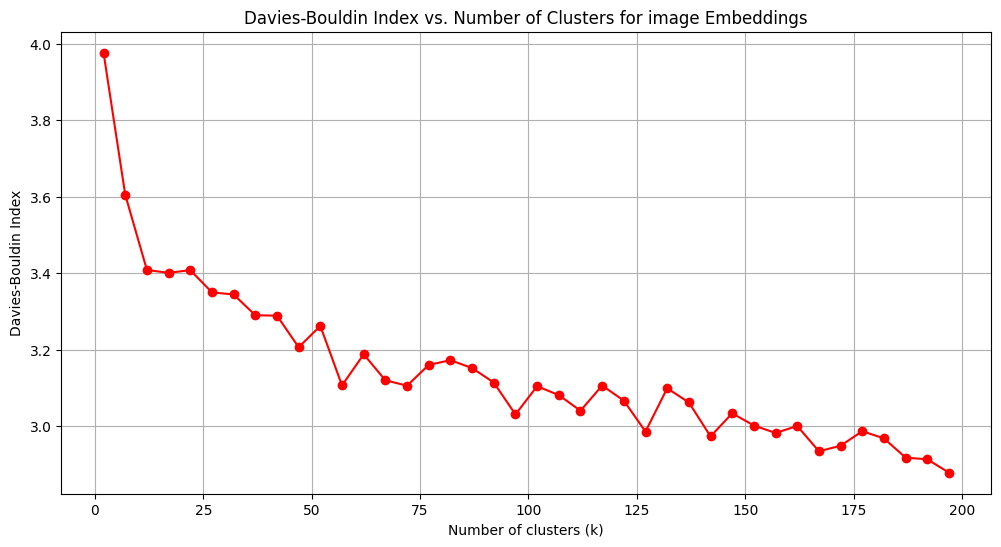

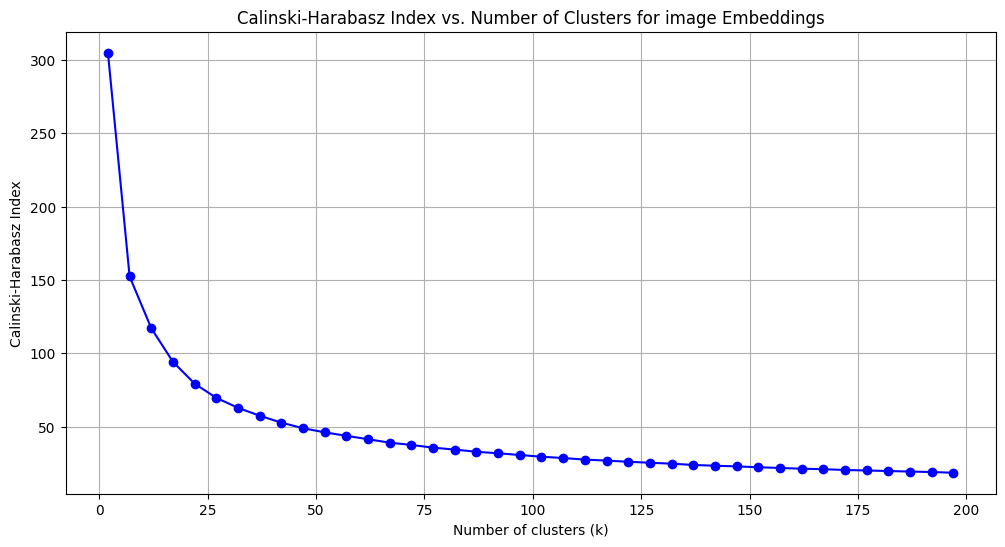

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images for image: 100%|██████████| 5000/5000 [00:00<00:00, 14473.83it/s]

Clustering complete for 71. Output saved to /data1/dxw_data/llm/redbook_final/script_next/random_sampled_cluster_imagebind3


In [5]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm
import shutil

# Paths
embedding_folders = {
    'image': '/data1/dxw_data/llm/redbook_final/script_next/random_sampled_image_embeddings',
}
output_folder = '/data1/dxw_data/llm/redbook_final/script_next/random_sampled_cluster_imagebind3'
os.makedirs(output_folder, exist_ok=True)

# Function to load embeddings
def load_embeddings(embedding_folder):
    embedding_files = [os.path.join(embedding_folder, fname) for fname in os.listdir(embedding_folder) if fname.endswith('.pt')]
    embeddings = []
    for embedding_file in tqdm(embedding_files, desc=f"Loading embeddings from {embedding_folder}"):
        embedding = torch.load(embedding_file)
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0).cpu()  # Move to CPU
    return embeddings, embedding_files

# Function to perform clustering and calculate DBI and VRC
def cluster_and_evaluate(embeddings, embedding_files, label, output_folder, embedding_folder):
    dbi_scores = []
    vrc_scores = []
    k_values = list(range(2, 201, 5))  # k values from 2 to 200 with a step of 5

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU
        
        if len(set(labels)) > 1:  # Check if we have more than 1 label
            dbi_score = davies_bouldin_score(embeddings.numpy(), labels)
            vrc_score = calinski_harabasz_score(embeddings.numpy(), labels)
            dbi_scores.append(dbi_score)
            vrc_scores.append(vrc_score)
        else:
            dbi_scores.append(float('inf'))  # Append a placeholder score if there's only one label
            vrc_scores.append(-1)  # Append a placeholder score if there's only one label
    
    # Plot Davies-Bouldin Index
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, dbi_scores, marker='o', color='red')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title(f'Davies-Bouldin Index vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'dbi_{label}.png'))
    plt.show()

    # Plot Calinski-Harabasz Index
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, vrc_scores, marker='o', color='blue')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title(f'Calinski-Harabasz Index vs. Number of Clusters for {label} Embeddings')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'vrc_{label}.png'))
    plt.show()

    # Select the optimal number of clusters based on the Davies-Bouldin Index (the minimum value)
    optimal_k_dbi = k_values[dbi_scores.index(min(dbi_scores))]

    # Perform clustering with optimal k (using DBI)
    kmeans = KMeans(n_clusters=optimal_k_dbi, random_state=0)
    labels = kmeans.fit_predict(embeddings.numpy())  # `embeddings` is now on CPU

    # Save clustered images to output folders based on the clustering results
    for idx, label in tqdm(enumerate(labels), desc=f"Saving clustered images for {label}", total=len(labels)):
        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)
        
        # Extract corresponding image file name from embedding file name
        embedding_file = embedding_files[idx]
        image_filename = os.path.basename(embedding_file).replace('_embedding.pt', '.png')
        
        # Define source image path
        source_image_path = os.path.join(embedding_folder.replace('combined_embeddings', 'combined_seg_img_pure_094'), image_filename)
        
        # Copy image to corresponding cluster folder
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, os.path.join(label_folder, image_filename))

    # Save clustering labels to JSON file
    labels_json = {os.path.basename(embedding_files[idx]): int(label) for idx, label in enumerate(labels)}
    with open(os.path.join(output_folder, f'{label}_labels.json'), 'w') as f:
        json.dump(labels_json, f)

    print(f'Clustering complete for {label}. Output saved to {output_folder}')

# Process each type of embeddings
for label, folder in embedding_folders.items():
    embeddings, embedding_files = load_embeddings(folder)
    cluster_and_evaluate(embeddings, embedding_files, label, output_folder, folder)
